In [1]:
from pathlib import Path
# add the root directory to the path
import sys
sys.path.append('..')

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from cloud_diffusion.utils import ls
from fastprogress import progress_bar
from utils import save_gif


In [2]:
from pathlib import Path
import wandb
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import h5py
import pandas as pd
import plotly.express as px




In [4]:
times_trainval = np.load(r"../data/times_trainval.npy",allow_pickle=True)

In [5]:
df_pv = pd.DataFrame(f['trainval']['pv_log'], index = times_trainval).resample("5T").mean().dropna()

df_pv = df_pv.rename(columns = {0: "pv_generation_W"})

px.line(df_pv, title = "PV Generation")



In [6]:
stamped_images = dict(zip(times_trainval, f['trainval']['images_log']))

start = pd.Timestamp('13-02-2018 00:00:00')
end = pd.Timestamp('14-02-2018 23:05:00')

dr = pd.date_range(start=start, end=end, freq='5T')


images = []
for i in dr:
    try:
        images.append(stamped_images[i])
    except:
        pass


In [174]:
# importing dataset class from pytorch

from torch.utils.data import Dataset, DataLoader
import os
import datetime

class DatasetSky(Dataset):
    def __init__(self, num_frames, path, type='train', use_every=5):
        self.use_every = use_every
        self.type = 'trainval' if type == 'train' else 'test'
        self.num_frames = num_frames
        self.data, self.pv_power, self.times = self._load_data(path)

    def __len__(self):
        return len(self.data) - self.num_frames - 1

    def __getitem__(self, idx):
        images = self.data[idx:idx+self.num_frames]
        times = self.times[idx:idx+self.num_frames]
        # convert to numpy
        images_numpy = np.asarray(images)
        images_numpy = np.mean(images_numpy, axis=-1) / 255 # convert to grayscale and normalize

        # Filter out frames from different days
        day = times[0].date()
        if any(t.date() != day for t in times):
            # If frames are from different days, return None
            return None
        return torch.from_numpy(images_numpy).float()
    
    def _load_data(self, path):
        with h5py.File(os.path.join(path, '2017_2019_images_pv_processed.hdf5'), 'r') as f:
            images = f[self.type]['images_log'][::self.use_every]
            pv_power = f[self.type]['pv_log']
        times = np.load(os.path.join(path, f"times_{self.type}.npy"),allow_pickle=True)[::self.use_every]
        return images, pv_power, times

        

In [189]:
ds_train = DatasetSky(50, '../data', type='test', use_every=10)

In [190]:
grscl = ds_train.__getitem__(0)

MovieWriter ffmpeg unavailable; using Pillow instead.


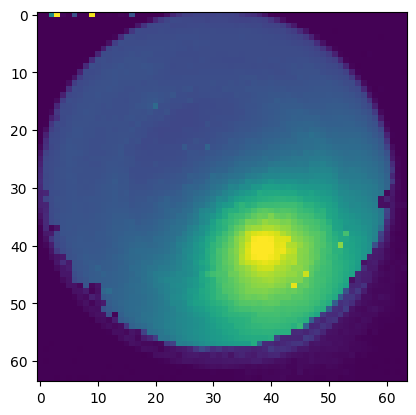

In [191]:
save_gif(grscl, '../gifs/test.gif')

In [197]:
from types import SimpleNamespace

from cloud_diffusion.utils import NoisifyDataloader, MiniTrainer, set_seed, parse_args
from cloud_diffusion.simple_diffusion import noisify_uvit, simple_diffusion_sampler
from cloud_diffusion.models import UViT, get_uvit_params


config = SimpleNamespace(    
    epochs = 100, # number of epochs
    model_name="uvit_small", # model name to save
    strategy="simple_diffusion", # strategy to use [ddpm, simple_diffusion]
    noise_steps=1000, # number of noise steps on the diffusion process
    sampler_steps=500, # number of sampler steps on the diffusion process
    seed = 42, # random seed
    batch_size = 6, # batch size
    img_size = 64, # image size
    device = "cuda", # device
    num_workers=8, # number of workers for dataloader
    num_frames=50, # number of frames to use as input
    lr = 5e-4, # learning rate
    n_preds=8, # number of predictions to make 
    log_every_epoch = 5, # log every n epochs to wandb
    use_every=10, # use every n frames
    )

def train_func(config):
    config.model_params = get_uvit_params(config.model_name, config.num_frames)

    set_seed(config.seed)
    device = torch.device(config.device)

    
    train_ds = DatasetSky(config.num_frames, '../data', use_every = config.use_every, type='train')
    valid_ds = DatasetSky(config.num_frames, '../data', use_every = config.use_every, type='test')

    # UViT dataloaders
    train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True, 
                                         noise_func=noisify_uvit,  num_workers=config.num_workers)
    valid_dataloader = NoisifyDataloader(valid_ds, config.batch_size, shuffle=False, 
                                          noise_func=noisify_uvit,  num_workers=config.num_workers)
    # model setup
    model = UViT(**config.model_params)

    # sampler
    sampler = simple_diffusion_sampler(steps=config.sampler_steps)

    # A simple training loop
    trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
    trainer.fit(config)


In [198]:

with wandb.init(project='skydiffusion', config=config, tags=["sd", config.model_name]):
    train_func(config)